Name: Bartol Bartulovic
Matricola: 2037915
Program: CN-2


Training a Deep Belief Network on the extended mnist dataset (emnist):
Generative graphical model  a class of deep neural networks, composed of multiple layers of latent variables ("hidden units"), with connections between the layers but not between units within each layer.

When trained on a set of examples without supervision, a DBN can learn to probabilistically reconstruct its inputs. The layers then act as feature detectors. After this learning step, a DBN can be further trained with supervision to perform classification.

Here I will first train the DBN and linear classifiers at different levels of the hierarchy and I will start to corrupt the sensory patterns, to see whether the model is robust to perurbations in its sensory data.

And to understand if the model is more or less sensitive at different levels of processing, probably higher the representation the more robust it could be to noise in the data.

Here we explore unsupervised learning in generative models and try to make sense of the representations that are discovered by these models.

Visualizing receptive fields and decoding the representations using linear classifiers and maybe probing the model injecting noise to understand how robust it is to sensory perturbations.

In [ ]:
# Function for implementing the Restricted Boltzmann Machine, made by flavio.
# The RBM can be trained with the contrastive divergence algorithm and can be embedded in a hierarchical
# model in the DBN class.

def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
# Used for implementing the linear readout classifiers later on
import torchvision as tv

from DBN import DBN

In [ ]:
# Choosing dynamically the kind of device used for computations (GPU)
# A cuda device speeds up training of the models. Setting cuda s a default device.
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [ ]:
# Compute the emnist pixelvalues in order to extract the mean pixel values for normalization.
emnist_pixelvalues = tv.datasets.EMNIST(root='./data', split='mnist', download=True)
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(emnist_pixelvalues.data.min(), emnist_pixelvalues.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(emnist_pixelvalues.data.float().mean(), emnist_pixelvalues.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(emnist_pixelvalues.data.float().mean() / 255, emnist_pixelvalues.data.float().std() / 255))

100%|██████████| 561753746/561753746 [00:05<00:00, 107941422.35it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 44.19263458251953 
Pixel Values Std: 84.588623046875
Scaled Mean Pixel Value 0.1733044534921646 
Scaled Pixel Values Std: 0.3317200839519501


In [ ]:
# https://arxiv.org/pdf/1702.05373.pdf
# https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html#torchvision.datasets.EMNIST
# The dataset has 6 different splits: byclass, bymerge, balanced, letters, digits and mnist.
# Split argument specifies which one to use
%%capture
emnist_train = tv.datasets.EMNIST('data/', train=True,
                                  download=True,
                                  split = 'mnist',
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize((0.1733,), (0.3317,))]  # here we use the mean and std computed on the MNIST training set
                                         ))

emnist_test = tv.datasets.EMNIST('data/', train=False,
                                 download=True,
                                 split = 'mnist',
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize((0.1733,), (0.3317,))]  # here I use the mean and std computed on the MNIST training set
                                         ))

In [ ]:
# Normalize:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255) # Why 255?

In [ ]:
print(emnist_train.data.shape)
print(emnist_test.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
              'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd',
                  'e', 'f', 'g', 'h', 'i', 'j',' k', 'l', 'm', 'n',
                    'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                      'y', 'z']

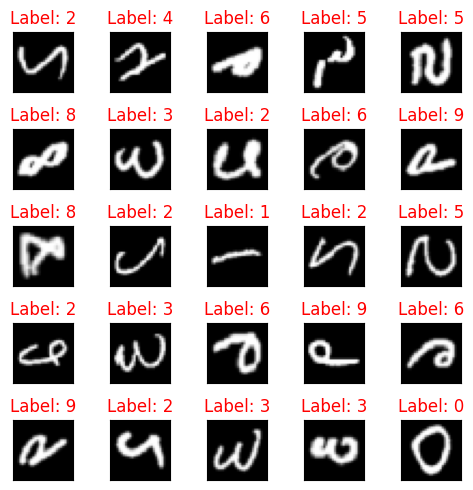

In [ ]:
# Plots/visualizes some examples of the emnist dataset.
import random
fig, axs = plt.subplots(5, 5, figsize=(5,5))
for i in range(5):
    for j in range(5):
        # Select a random index
        idx = random.randint(0, len(emnist_train) - 1)

        # Plot the image
        img = emnist_train.data[idx]
        label_idx = emnist_train.targets[idx]
        label = labels[label_idx]
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title("Label: {}".format(label), color='red', fontsize=12)
        axs[i, j].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

plt.tight_layout()
plt.show()

The letter shown is the letter: 9


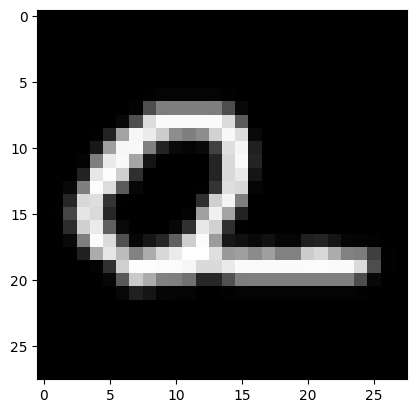

In [ ]:
# Printing one example
idx = random.randint(0, len(emnist_train) - 1)
img = emnist_train.data[idx]
print("The letter shown is the letter: {}".format(emnist_train.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [ ]:
# Converting the target labels of the dataset to a GPU
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)

In [ ]:
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

Training the DBN -

Deep belief networks are probabilistic generative models that are consist of multiple layers of stochastic, latent variables. The latent variables typically have binary values and are often called hidden units or feature detectors. The top two layers have undirected, symmetric connections between them and form an associative memory. The lower layers receive top-down, directed connections from the layer above. The states of the units in the lowest layer represent a data vector.

Building a hierarchy of feature detectors that can be used to reconstruct data.

The two most significant properties of deep belief nets are:

There is an efficient, layer-by-layer procedure for learning the top-down, generative weights that determine how the variables in one layer depend on the variables in the layer above.
After learning, the values of the latent variables in every layer can be inferred by a single, bottom-up pass that starts with an observed data vector in the bottom layer and uses the generative weights in the reverse direction.
Deep belief nets are learned one layer at a time by treating the values of the latent variables in one layer, when they are being inferred from data, as the data for training the next layer. This efficient, greedy learning can be followed by, or combined with, other learning procedures that fine-tune all of the weights to improve the generative or discriminative performance of the whole network.

### Visible units
This parameter specifies the number of units in the visible layer. In your case, it's set to 28*28, which corresponds to the size of the EMNIST images, assuming they are 28x28 pixels. This sets the dimensionality of the input data.

### Hidden Units
This is a list that defines the number of hidden units in each layer of the DBN. In your configuration, you have three hidden layers with 400, 500, and 800 units, respectively. These layers capture progressively more complex features as you move deeper into the network.

### K
Determines the number of Gibbs sampling steps used in Contrastive Divergence (CD) training. In your case, it's set to 1, meaning you perform one Gibbs sampling step during training.


### learning_rate
It controls how quickly the model adapts to the training data. A higher learning rate makes the model learn faster but may lead to convergence issues (overshooting minima and maxima), while a lower learning rate makes the learning process more stable but slower (we might get stuck in local minima and maxima). You've set it to 0.1.

### learning_rate_decay
When set to True, this parameter enables a learning rate decay schedule, which gradually reduces the learning rate during training. In your configuration, it's set to False

### initial_momentum and final_momentum:
Momentum helps the optimization process by allowing the model to overcome local minima. The momentum starts at the initial value (0.5) and gradually increases to the final value (0.95) during training.

### weight_decay:
Weight decay is a regularization technique that penalizes large weights to prevent overfitting. I've set it  to 0.0001, resulting in a small weight decay penalty.

### xavier_init:
When set to True, this parameter enables Xavier initialization for the weights. Xavier initialization is a technique to initialize the weights of neural network layers to keep the gradients stable during training. In this configuration, it's set to False, meaning random weight initialization is used.

### increase_to_cd_k:
Increasing the number of Gibbs sampling steps (CD-k) during training. In my configuration, it's set to False, indicating that I will not use this feature.

### use_gpu:
Checks if a GPU is available for training and uses it if it is. If my system has a compatible GPU and PyTorch is set up to use it, this will speed up training.

In [ ]:
# Train the DBN
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[200, 300, 600],# I can change the layers (amonut of hidden units here) including layers to try to caputre the emnist distribution
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,# Parameters can be tricky.
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,# We preserve some parts of the previous updates and previous weights in the updates
                xavier_init=False,# Initialization technique using for the weights: here I use random procedure
                increase_to_cd_k=False,# I didnt look into it: never used it.
                use_gpu=torch.cuda.is_available())

In [ ]:
num_epochs = 50 # I trained the network for 50 epochs which means that we trained each layer for 50 epochs. CHeck downstairs
batch_size = 125 # The batch size defines the number of samples that will be propagated through the network, before the model (weights) is/are updated.



dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)





--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4084     |0.0509       |218.1140   |4.6295     |
|20    |1.3407     |0.0470       |210.9951   |4.3849     |
|30    |1.3197     |0.0465       |208.7712   |3.8215     |
|40    |1.3052     |0.0449       |205.3327   |4.4687     |
|50    |1.3044     |0.0445       |205.8271   |4.5630     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.6110     |0.0827       |112.0976   |2.5302     |
|20    |2.4134     |0.0756       |105.0501   |1.7549     |
|30    |2.3786     |0.0689       |103.8638   |2.0278     |
|40    |2.3662     |0.0693       |103.5503   |2.2990     |
|50    |2.3491     |0.0690       |102.6943   |1.7339     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5626     |0.0490       |163.5190   |3.3500     |
|20    |1.4102     |0.0434       |144.4122   |2.729

We are training all the three layers in a greedy way. First layer, first, then freezing the connections followed by the the second etc.

The average reconstruction error should decrease steadily during the training.
This means that the gradient is correctly propagating and the contrastive divergency is doing what it should do. This error is used to assess how faithfully the model can capture and reproduce the essential information from the input data.

Mean_grad and std_ grad should stay in a reasonable range, so the gradient does not explode or vanish.

In a DBN we train layers in a greedy way. We train first the first then the second then the third layer.In principle one could do it jointly from bottom to top in a single procedure: done with autoencoders or variational autoencoders
But DBN it is more efficient to stack layers independently. Implementing a variational autoencoder Imight improve the results, because VAE trains the entire architecture. And every layer can talk to the other layers during training. Which is not whats happening in this case.

## Receptive Field visualization

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy() #Using numpy arrays instead of pytorch tensors

def apply_threshold(weights, threshold=0): #Weights
  return weights * (abs(weights) > threshold) # Keeping the weights that have an absolute value above the threshold


def plot_layer_receptive_fields(weights): # Construct the cool plots beneath
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # Here I select the weights we want to plot
    # select here some rows: 100 neurons: but within our first layer we had 500 neurons right.
    # So we jsut visualize some of them.

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

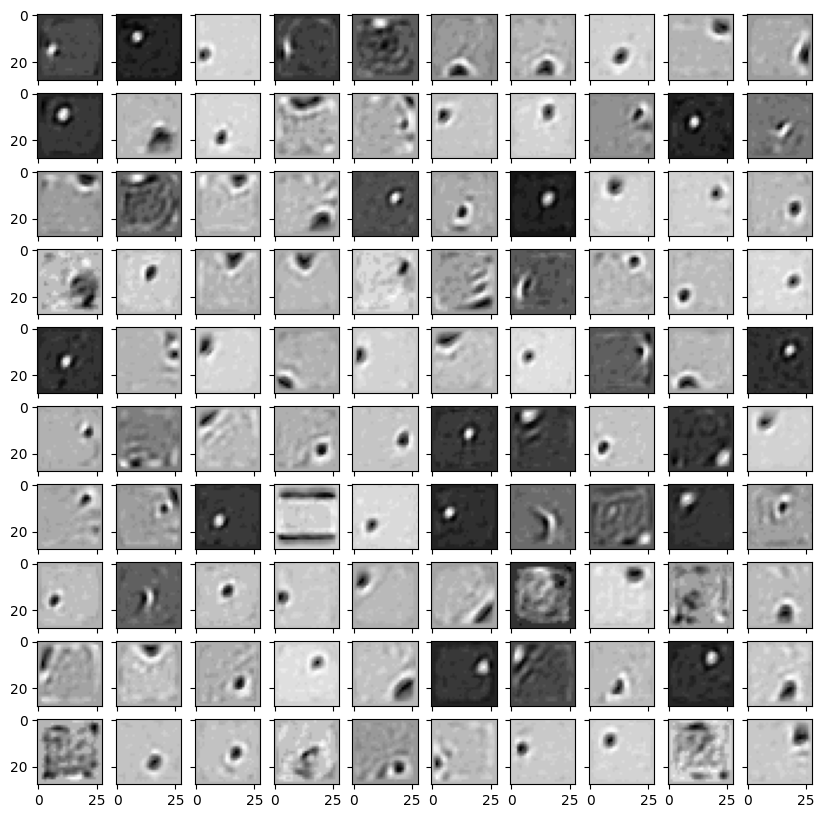

In [ ]:
# First we get layers, we apply a threshold (

learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)


THis is the visualization of the first layer of the hidden weights
We are saying each of these squares is one of the first hidden layer.
DBNs often consist of layers of Restricted Boltzmann Machines (RBMs). In an RBM, each visible unit is connected to all hidden units and vice versa. The receptive field of a hidden unit in the first hidden layer of an RBM is defined as the set of visible units that are connected to it. This receptive field indicates which parts of the input data the hidden unit "sees" or responds to.
Each node of the first hidden layer is connected to all of the visible units
So to all pixels of the image.

What we do here is we ask what are the pixels in the original image
Which cause the particular neuron to activate what is the neuron tuned to (responding to).

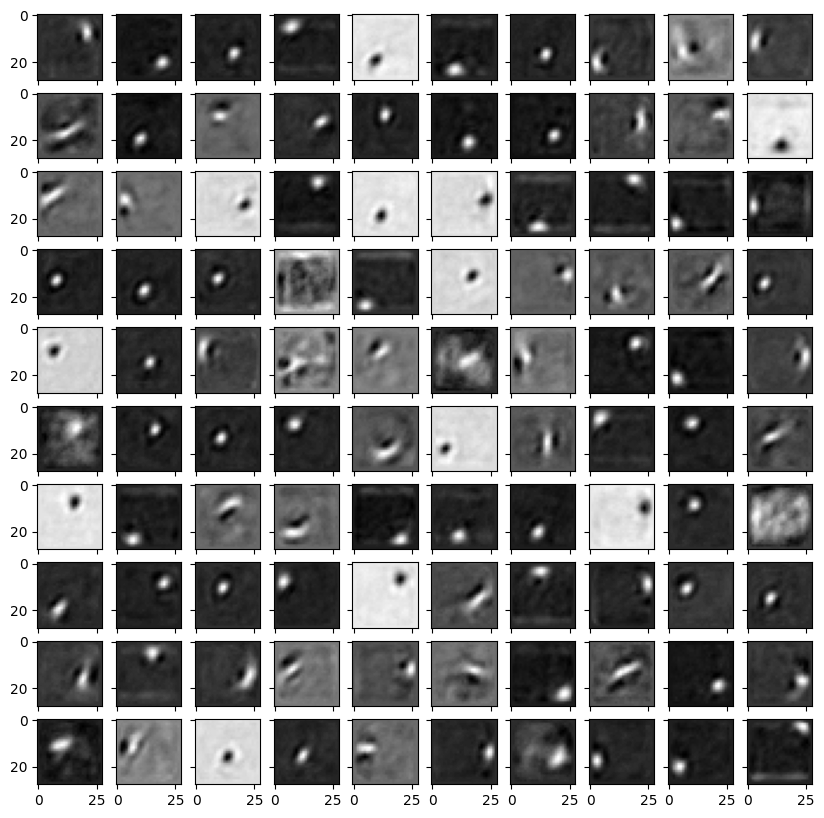

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # Here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)#simple matrix product transformation

It gets more complex in the second hidden layer, because we need to take into account that the
second hidden layer is not connected to the input/image. It is connected to the hidden representations. As we move up the layers in a DBN, the receptive fields become more abstract and complex. In other words, higher-level hidden units respond to patterns and features that are more global and less tied to specific local details. This hierarchical organization allows DBNs to capture increasingly abstract features or representations of the emnist input data.

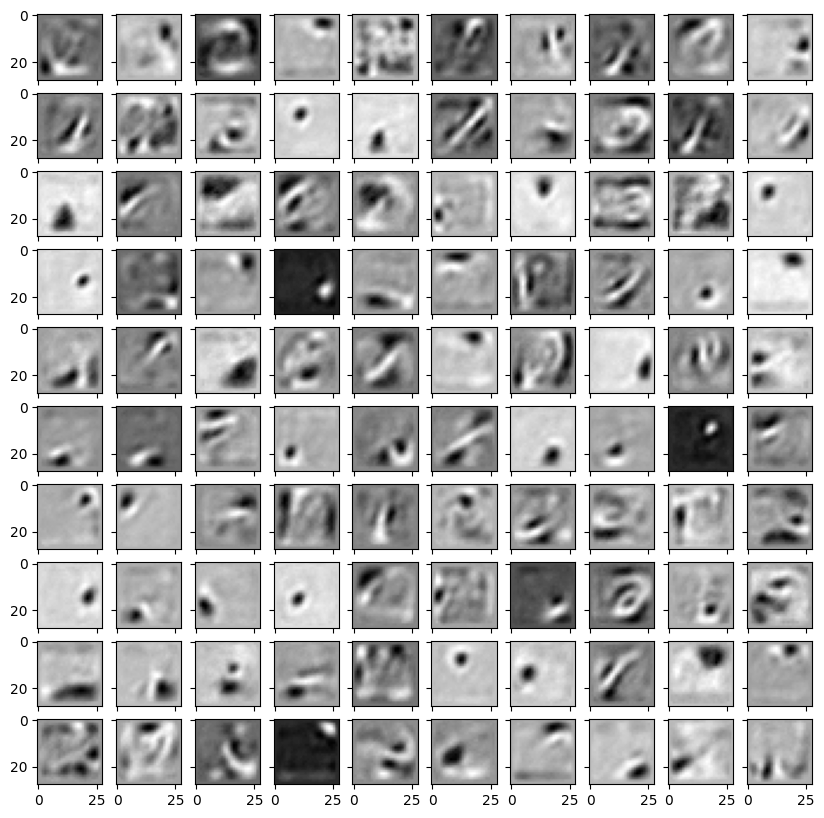

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)


We can see that some weights are sensible to specific points in the image.
We see something that should be in the second layer (increasingly complex hidden representaitons).


These should be sensible to strokes
IN the last layer maybe we could see even more. e.g circles in 9 8 and 6 and approximations of shapes.

This is losely inspired by hierarchical visual processing in the human brain.
Processing starts with the detection of low-level visual features, such as edges, corners, and textures. These features are extracted at the earliest stages of visual processing and serve as the foundation for higher-level analysis. Neurons in the primary visual cortex (V1) are tuned for detecting edges and contours in the visual field. They respond to variations in luminance and orientation, helping to create an initial representation of object boundaries and shapes. Moving further up the hierarchy of visual processing, different neurons in the visual system become sensitive to specific spatial frequencies. High spatial frequencies correspond to fine details, while low spatial frequencies represent coarse information. The combination of spatial frequencies helps in perceiving global object shapes and textures. As processing proceeds up the hierarchy, neurons become more tuned for specific object features. They respond to more complex patterns, such as faces, letters, or objects. This stage is critical for recognizing familiar objects and faces.

## Linear Readouts

Extracting the hidden representations of the data, by propagating the neuron's activations from the sensory (visible) layer in a bottom-up fashion, and try to lineary decode the content of the representations in a supervised way.


Linear classifiers are used to understand how separable are our hidden representations. If a linear classifier achieves a high accuracy, that means that the representations are highly disentangled. So the model discovers high level abstract representations. If it has poor performance, than the generative model did not discover separable features, or a proper set of features. THen maybe the hierarchy or hyperparameters need to be tuned.

In [ ]:
# Function to get the hidden state of the kth layer. Can be first second or third layer.
# Sending some input to the network, converting it to a torch tensor and sending it to a device (GPU )
# and taking the hidden representations at layer K. using some built in functions that you can find in a DBN module.
# First getting the hidden representations: Saving the representations corresponding to the data.
# We use it to store all three levels of representations

def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
# For second representation the input is the hidden representation at the preceding level
# For the third layer is the hidden representation at the second level.
# We do this for all the hidden layers.
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
# Defining a linear classifier (single layer with 10 output neurons from 0 to9): using the torch linear module.
# Just using a single layer: no hidden layers:
# A single layer classifier: Linear classifier to map the hidden representations
# At the different levels of the hierarchy into sueprvised classes.
# How good is the first hidden layer to disentangle information of the emnist digits & letters.
# That allows to classify them into the classes.

# After defining the linear classifier we can apply it to the first second and third hidden layer and
# then define the training function for the linear classifier. Previously it was called train linear. Now I call it just train.

# Because I use the exactly the same train function for training the feed forward multilayer perceptron.
# By default we I 1500 epochs. Multiclass

class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
# Apply the linear classifier to first second and third hidden layers
# Creating three different read-out linear models
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [ ]:
# Pytorch: Tensorflow: High level programming environments for developing DL models
# Can automatically differentiate a loss function for you: Doesnt depend on the amount of layers
# Relus, sigmoids, dropouts, batch normalization etc. momentum, normalization regulraiztraion
# As soon as you define a loss function: Cross entropy, mean square error whatever
# Pytorch will automatically differentiate it with respect to the parameters in the model
# First you define the loss function and then you call the backward function which is computing the gradient of the loss function for you.
# Backpropagating the gradients.

# Define the training function for the linear classifier. In the lab this function was called train linear.
# Now I call it just train, because we use exactly the same train function for training the feed forward multilayer perceptron.
# So just call it train.
# General gradient descent function allowing to tune the wieghts according to a supervised criterion: using stochastic gradient descent and cross entropy
# as a loss function iterating over 1500 epochs.

def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss() # It is a multiclass supervised classification so we use cross entropy as a loss fucntion.

  epochs = 1500 # 1500 epochs

  for epoch in range(epochs): # We just cycle through the epochs. Computing the gradient
    optimizer.zero_grad() # Fairly standard function for supervised learning with pytorch!
    predictions = linear(hidden_reprs).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward() # And backrpopagating the gradient using backpropagation. Standard pytorch function.
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
# Training the readout classifiers in the three hidden layers. The loss function should decrease here!
# Again using a different dataset, you might need a different amount of epochs.
# I might implement something to stop early training phase. Or other advanced methods (cross validation for example)
train_linear(linear1, hidden_repr_layer_1)

epoch :   1/1500, loss = 2.2945
epoch : 101/1500, loss = 0.8513
epoch : 201/1500, loss = 0.5940
epoch : 301/1500, loss = 0.4910
epoch : 401/1500, loss = 0.4336
epoch : 501/1500, loss = 0.3961
epoch : 601/1500, loss = 0.3693
epoch : 701/1500, loss = 0.3489
epoch : 801/1500, loss = 0.3328
epoch : 901/1500, loss = 0.3196
epoch : 1001/1500, loss = 0.3085
epoch : 1101/1500, loss = 0.2991
epoch : 1201/1500, loss = 0.2909
epoch : 1301/1500, loss = 0.2838
epoch : 1401/1500, loss = 0.2774


In [ ]:
train_linear(linear2, hidden_repr_layer_2)

epoch :   1/1500, loss = 2.3221
epoch : 101/1500, loss = 0.7770
epoch : 201/1500, loss = 0.5434
epoch : 301/1500, loss = 0.4498
epoch : 401/1500, loss = 0.3971
epoch : 501/1500, loss = 0.3623
epoch : 601/1500, loss = 0.3373
epoch : 701/1500, loss = 0.3182
epoch : 801/1500, loss = 0.3030
epoch : 901/1500, loss = 0.2905
epoch : 1001/1500, loss = 0.2800
epoch : 1101/1500, loss = 0.2711
epoch : 1201/1500, loss = 0.2633
epoch : 1301/1500, loss = 0.2564
epoch : 1401/1500, loss = 0.2503


In [ ]:
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 2.3058
epoch : 101/1500, loss = 0.7593
epoch : 201/1500, loss = 0.5187
epoch : 301/1500, loss = 0.4239
epoch : 401/1500, loss = 0.3711
epoch : 501/1500, loss = 0.3367
epoch : 601/1500, loss = 0.3120
epoch : 701/1500, loss = 0.2932
epoch : 801/1500, loss = 0.2783
epoch : 901/1500, loss = 0.2661
epoch : 1001/1500, loss = 0.2558
epoch : 1101/1500, loss = 0.2471
epoch : 1201/1500, loss = 0.2395
epoch : 1301/1500, loss = 0.2328
epoch : 1401/1500, loss = 0.2269


In [ ]:
# Get the hidden representations layers first second and third layer using the test data.
# Repeat the code and get the predicitons of inear classifier using the representations of the test data that we just calculated.
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [ ]:
# Computing the predictions
# test how good is the classifier on the test data. So we get the hidden layer representations. Using the test data.
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [ ]:
# Measuring the accuracy of the classifier, by finding from the probabilities,
# what is the class receiving the highest probability I select that.
# then computing the difference with the target vector.
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
# Accuracy for hidden layers: Accuracy increase as we move up the hierarchy. Which makes sense.
# Maybe partially due to having more hidden units! 200,300,600 maybe also why the linear classifier is better at the third layer.
# Because we are projecting the data into a higher dimension space if we compare it to e.g the first hidden layer.
print("Accuracy - 1st layer: ", compute_accuracy(predictions_test1, emnist_test.targets))
print("Accuracy - 2nd layer: ", compute_accuracy(predictions_test2, emnist_test.targets))
print("Accuracy - 3rd layer: ", compute_accuracy(predictions_test3, emnist_test.targets))

Accuracy - 1st layer:  0.9261999726295471
Accuracy - 2nd layer:  0.9362999796867371
Accuracy - 3rd layer:  0.9435999989509583


## Clustering internal representations

In [ ]:
# A function that gets the representations at a certain layer.
# This just uses the structure of the DBN class. We have some RBM layers
# We just go and compute the hidden representation using this layer

def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
# Gets for us the representation at a certain layer.
# But we need to be careful using this function, because in the first case layer 0
# we give as input the actual digits.
# In the second layer case we give as input the hidden representations of the first one.
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }
# We take the mean vectors from the dictionary we ask its shape and concccatenate it into the matrix
# It is very technical and not necassirly needed to understand
def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

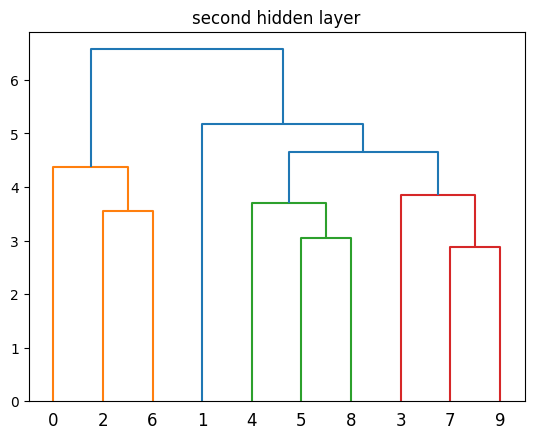

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_2, "second hidden layer")

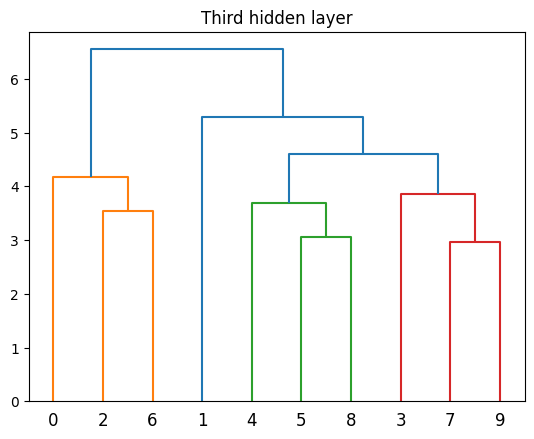

In [ ]:
# The height of the archs in the plot represent in what time the element
# was grouped with some other groups
# Most similar elements are grouped immediately: which are those in the lower parts of the diagram
# grouped immediately ().
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Robustness to Noise: Noise injection

Now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

Challenge the models: If I give you clean mnist test data you get 94 % but if you get noisy data are you still able to classifiy them with 94% of accuracy.

Maybe the performance will drop. Nad how fast it will drop will be characterized by psychometric curves.

If we systematically test the model using many levels of noise.
we can also see how robust it is to icnreasing perturbations in the sensory data.

In [ ]:
# Defining a simple function for injecting some noise.
# Takes as input the entire emnist data( a big matrix as many rows as number of patterns/ and as many
# columns as number of pixels in the image ) to inject some noise.

# I could also try to inject binary noise here.
# first get the shape of emnist data 60000 by 784 (if thats the training set) e.g and specifiy in which device we want to move the data.
# Which is very important: otherwise I will get some errors ( Data is in the gpu, creating noise in the cpu sum them and it goes crazy. )
# And then multiplay by the noise level. Which is 0.3 (creating a gaussian with sd equal to noise level )
# some gaussian to the mnist data.

def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level # Create a random gaussian tensor by using torch.randn. Of the same size of the entire dataset.
  return emnist_data + random_gaussian_tensor

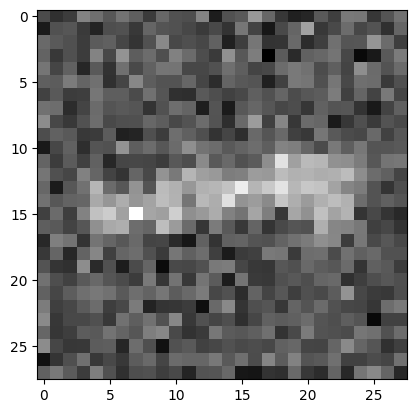

In [ ]:
# Print out image containing noise. I can specifiy the noise level using the noise level parameter. By a scalar number.
noise_level = 0.3
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

Here I will now compute the hidden representations for the noisy images using the DBN.

Then, I will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [ ]:
# Pass a noise level:
def get_accuracy_values_at_noise_level(noise_level):
# Inject noise to emnist dataset. New test data.
  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

# Getting the first second and third hidden layer representations: using the noisy data as the input.
  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

# Get the prediction for the first second and third hidden layers using the representations that are noisy.
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

# Computing the accuracy using noisy reps.
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)


  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden

In [ ]:
# Accuracies at a specific noise level!
# First DBN level of 0.3 etc.
# Feed forward 90%
# Now as we put noise data the difference between the DBN and FF
# becomes more pronounced.

# so first hidden layer is dropping quite fast. to 90% second is staying to 92
# third is quite robust.

acc = get_accuracy_values_at_noise_level(0.2);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])

Accuracy of H1 read-out: 0.919
Accuracy of H2 read-out: 0.933
Accuracy of H3 read-out: 0.941


In [ ]:
# PSychometric curve: Systematically varying the noise levels.
# Create a new function so we get an array of noise levels.
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []

# We loop across all noise levels.
  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])


  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)


  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden"])

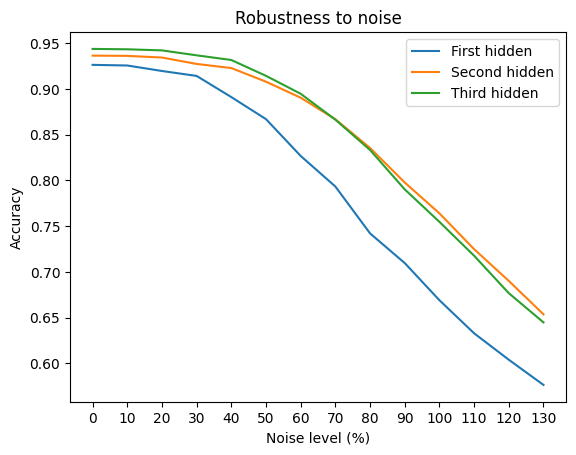

In [ ]:
# Systematically exploring all the noise levels.
# How the accuracy decreases as we increase the noise levels.

# The first hidden layer accuracy drops pretty quick as we increase noise levels.
# But for second and third the representations are very much resistant to perturbations in the sensory input.

# After all: The DBN models ( in terms of accuracy ) perform almost the same 90-94%
# but  if you challenge the model and perturb the sensory input, you will see huge differences
# So accuracy is not enough, we also want to study the resilience of the observer to noise in cog. science.
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

Naturally the accuracy drops for all hidden layers as we increase the noise levels, however the third hidden layer is the most robust, because it has established more robust and abstract representations.

## Adversarial Attack using Fast gradient sign method

Reference: https://jaketae.github.io/study/fgsm/

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure:
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$



WIth Backprop and any gradient descent algorithm you can see what the relationship is between the parameter( connection weight) and the loss function. Usually we change the parameters in order to minimize the loss function. So we follow the direction opposite of the gradient to change the parameters.

We keep the parameters fixed, so we dont aim at tuning the parameters but we can calculate the gradient with respect to the pixels: The input itself. If you change the pixels you will have a change in the loss.

Maybe that pixel is disturbing the model that is somehow misclassifying the input. SImilar to backprop we can compute the gradient of the loss function, not with respect of the model parameters, but with respect to the input pixels. THis way we can minimize or increase the loss.

SO attacking means manipulating the pixels (injecting noise), that the loss function increases. We are acting on the input itself not the model parameters.

In [ ]:
# Function Takes as input an imag, epsilon = strength of the attack noise levels, increasing epsilon means increasing noise.
# But if i am attacker I shouldn't use a too high epsilon, because a human might detect it.
# Its a tradeoff between strength of the attack and being caught.
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [ ]:
# Define a DBN class readout. We trained the DBN in a greedy unsupervised way and trained the readout separately. SO
# SO the gradient must flow from the loss of the readout to the DBN to the input.
# Setting up this new class making it possible to compute a forward pass from the input to the readout output.

class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
# The previous dbn + the redout layers.
# We sepcifiy for the target of the attack is the second level which is the topmost hidden layer.
# Python starts counting from 0.
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

(-0.5, 27.5, 27.5, -0.5)

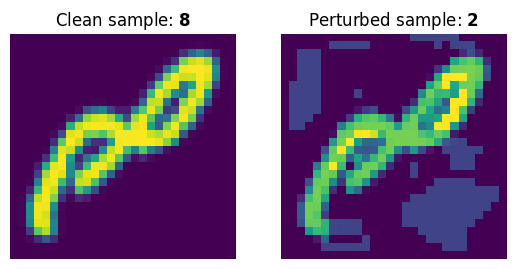

In [ ]:
test_sample_idx = 6
epsilon = 0.2  # define strenght of the attack. Medium to strong attack.

fig, (ax1, ax2) = plt.subplots(1, 2)

# Clean sample: Create a test image. Find the label:
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
ax1.imshow(test_image.reshape(28,28).to('cpu'))

test_image.requires_grad_()
model_outputs = dbn_with_readout(test_image)
prediction = torch.argmax(model_outputs).item()
predicted_label = labels[prediction]
ax1.set_title( f"Clean sample: $\\bf{{{predicted_label}}}$")
ax1.axis('off')

# Perturbed sample
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value: Loss function for that particular image. The performance of the model when feeding that part. image.
dbn_with_readout.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # compute the gradient of the pixels w.r.t. the loss. Trying to understand how we should change the test image in order to max. the loss.
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
ax2.imshow(perturbed_image_np.reshape(28,28))

model_outputs = dbn_with_readout(perturbed_image.view((perturbed_image.shape[0], -1)))
predicted_class = torch.argmax(model_outputs).item()
predicted_label = labels[predicted_class]
ax2.set_title( f"Perturbed sample: $\\bf{{{predicted_label}}}$")
ax2.axis('off')

It is not exactly gaussian noise. We can see some patterns, but interestingly the model classifies the 8 as being a digit number 2. THerefore, we do not really perceive the attack as humasn, however our model gets confused, even if there is no clear evidence of noise.

Before our model was pretty strong in resisting gaussian noise. We were putting so much graussian noise and the human eye was not able to say it is number 2, but with just a little bit of noise, the model gets totally confused by the attack. That is how powerful adversarial attacks are: going into a specific direction of the loss making models to missclassify them.

## Resistance to attacks

Trying to reconstruct the input itself before classification.We have an image e.g digit nr 2. an attacker changes the pixels in order to make the model classify it as a 6, but the model is trying to reconstruct the digit as a first thing to do using top down processing. And it should usually remove the corrupted pixels. It is a good way of exploiting the top down processing capabilities of a deep believe network. It is also inspired by biological visual processing in which massive top-down feedback projections help the perceiving, or predictive brain to fill in gaps while perceiving ambigiuity, noise and uncertain visual input.

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as functional
# Num of steps.:how many top-down reconstruction sets one wants to preform with a DBN.
# We can start with noisy data and denoise it. By doing a bottom up pass by hierarchy
# And a dtop down pass of reconstruction
# Similarily to an autoencoder.
# If numsteps greater than 0 we are trying to reconstruct the data using the reconstrtuct function and visualizing it.

def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)



        if (print_reconstruction and verbose):
          ax1.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          ax1.set_title('Original sample',fontsize=10)
          ax1.axis('off')

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):

            ax2.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            ax2.set_title('Perturbed sample', fontsize=10)
            ax2.axis('off')

        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):

                ax3.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                ax3.set_title(f' {num_steps}-steps reconstructed sample', fontsize=10)
                ax3.axis('off')
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:

test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False,split = 'mnist', download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 84.76%



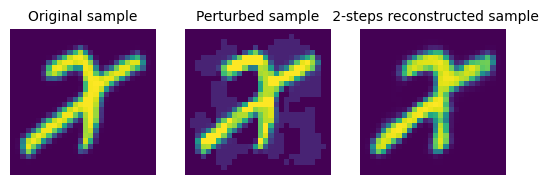

In [ ]:
# Increasing the epsilon we can see a decrease in test accuracy.
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=2)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 84.83%



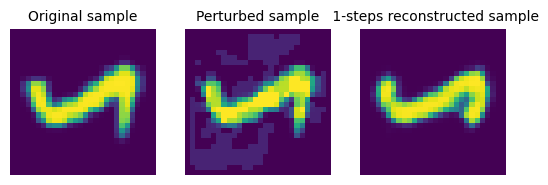

In [ ]:
#
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

We have some input data which is recognazible by our eyes. We can perturb it adding handcrafted noise that is systematically making the network to misclassify. We can defend by taking the perturbed image and try to reconstruct it. ONe forward step activating the hidden layers and a top down step reconstructing the data itself. And the DBN can reconstruct the input data itself. And the reconstructed data is without noise. The DBN can remove the injected noise by the attacker. A powerful way to simply defend against an attack. As we increase the noise, however, the reconstruction becomes worser and worser. Increasing the noise however too much and the DBN cannot reconstruct the image anymore.

## Effect of noise parameter E

Scientifically studying the effect of the noise parameter epsilon in the attack. We define an array with different levels of noise again and systematically compute the accuracy on the test data for different models.

Readout without defense and with reconstruction steps ( one step of topdown processing)

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

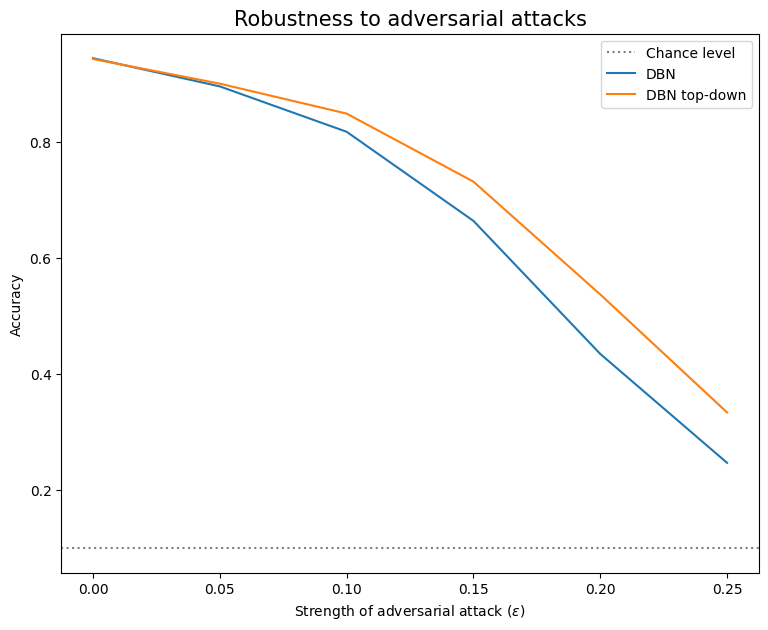

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level","DBN", "DBN top-down"])

Visualizing the psychometric curve: THe DBN in its purest form is less robust than the top-down reconstruction DBN.The drop of the accuracy of the model is steeper than that of the top-down DBN model. This means that already involving one step of reconstruction the model can be made more robust to perturbations, or uncertainties in the sensory input. We can denoise the data and resist better to adversarial attacks that try to destabilize the model.

We can easily exploit the power of generative models to denoise the data and defend an attacker.

Moreover, this project shows how we can build simulations of visual processing done in psychophysical experiments. e.g visual processing under ambiguous sensory input.

It fits particularly well to contemporary neuroscientific perspectives on  Bayesian Brain Theory (or the predictive brain), a computational approach which is derived from the principles of Predictive Processing (PP). It offers a mechanistic and mathematical formulation of these cognitive processes. This theory assumes that the brain encodes beliefs (probabilistic states) to generate predictions about sensory input, then uses prediction errors to update its beliefs.

Physiologically speaking, a parallel can be found in how the brain processes visual input. We today know that massive top down feedback projections are capable of modulating selectively tuned neurons up to low level processing units in the primary visual cortex (V1).

Psychophysical experiments show that these projections are crucial for prediction and perception under ambiguous or noisy sensory stimuli (e.g filling in phenomena). Which is similar to what we see in generative models that use reconstruction to withstand adversial attacks and noise within sensory input.